In [10]:
import pandas as pd
import numpy as np
from src.datasets import compile_data, LFP_Dataset, Dataset_Manager
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
label_file = "/media/HlabShare/Aidan_Work/SleepScores/CAF26_consensus.npy"
probe_files = [
    '/media/HlabShare/Sleep_Scoring/CAF00026/caf26_08072020/*/probe1/co/*lfp_group0.npy',
    '/media/HlabShare/Sleep_Scoring/CAF00026/caf26_08072020/*/probe2/co/*lfp_group0.npy',
    '/media/HlabShare/Sleep_Scoring/CAF00026/caf26_08072020/*/probe3/co/*lfp_group0.npy'
]

In [12]:
sfreq = 500
bin_size = 4 * sfreq


sleep_labels = np.load(label_file)
all_probe_data = np.concatenate([compile_data(f) for f in probe_files])
sleep_labels = np.concatenate([sleep_labels] * 3)
sleep_labels = sleep_labels -1

# Reshaping
raw_data = all_probe_data
sleep_states = sleep_labels
sequence_length = 2000  # Number of time points in 4 seconds
num_sequences = len(raw_data) // sequence_length
X = raw_data[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
X = torch.tensor(X, dtype=torch.float32)
y = sleep_states[:num_sequences]
y = torch.tensor(y, dtype=torch.long)

In [13]:
dm = Dataset_Manager(X, y)
dataloader = dm.get_train_loader(batch_size=32)

In [14]:
from src.models import ConvAutoencoder, ClassDecoder
from torch import nn
from torch import optim


# Initialize the encoder with classifier
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop for classification
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, _ in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Classifier Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Classifier Epoch [1/10], Loss: 588.9328
Classifier Epoch [2/10], Loss: 360.5461
Classifier Epoch [3/10], Loss: 249.7449
Classifier Epoch [4/10], Loss: 240.4285
Classifier Epoch [5/10], Loss: 150.7247
Classifier Epoch [6/10], Loss: 118.8231
Classifier Epoch [7/10], Loss: 110.8104
Classifier Epoch [8/10], Loss: 107.3675
Classifier Epoch [9/10], Loss: 103.0941
Classifier Epoch [10/10], Loss: 100.0352


In [15]:
classifier = ClassDecoder(model)
criterion = nn.NLLLoss(weight=torch.tensor([0.05, 0.05, 0.90]))
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Classifier Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Classifier Epoch [1/10], Loss: 0.7643
Classifier Epoch [2/10], Loss: 0.6059
Classifier Epoch [3/10], Loss: 0.5477
Classifier Epoch [4/10], Loss: 0.4955
Classifier Epoch [5/10], Loss: 0.4554
Classifier Epoch [6/10], Loss: 0.6568
Classifier Epoch [7/10], Loss: 0.3436
Classifier Epoch [8/10], Loss: 0.4553
Classifier Epoch [9/10], Loss: 0.3220
Classifier Epoch [10/10], Loss: 0.3235


Accuracy: 0.6432098765432098
Precision: 0.8104993400250989
Recall: 0.6432098765432098
F1 Score: 0.7021220256598466


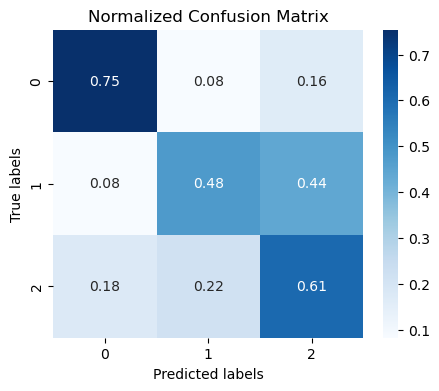

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

dataloader = dm.get_test_loader()

# Assuming test_loader is a DataLoader for your test set
true_labels = []
pred_labels = []
classifier.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation
    for inputs, labels in dataloader:
        outputs = classifier(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Append actual and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalization can be applied by setting 'normalize=True'
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# Plotting the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

# Labels, title and ticks
label_classes = np.unique(true_labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(label_classes)
ax.yaxis.set_ticklabels(label_classes)
plt.show()

In [19]:
dataloader = dm.get_train_loader(batch_size=32)

class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=128*125):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(encoded_space_dim, 3)  # Assuming you have 3 classes

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize the encoder with classifier
classifier_model = Encoder()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

# Training loop for classification
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = classifier_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Classifier Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Classifier Epoch [1/10], Loss: 0.2811
Classifier Epoch [2/10], Loss: 0.2575
Classifier Epoch [3/10], Loss: 0.2454
Classifier Epoch [4/10], Loss: 0.2483
Classifier Epoch [5/10], Loss: 0.2257
Classifier Epoch [6/10], Loss: 0.3330
Classifier Epoch [7/10], Loss: 0.3428
Classifier Epoch [8/10], Loss: 0.2033
Classifier Epoch [9/10], Loss: 0.2191
Classifier Epoch [10/10], Loss: 0.0594


Accuracy: 0.8170524691358024
Precision: 0.8241569400216815
Recall: 0.8170524691358024
F1 Score: 0.8203424362582882


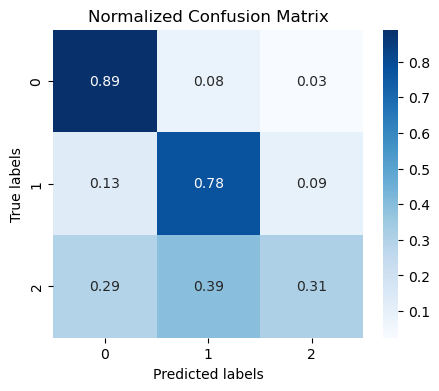

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

dataloader = dm.get_test_loader()

# Assuming test_loader is a DataLoader for your test set
true_labels = []
pred_labels = []
classifier_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation
    for inputs, labels in dataloader:
        outputs = classifier_model(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Append actual and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalization can be applied by setting 'normalize=True'
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

# Plotting the confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')

# Labels, title and ticks
label_classes = np.unique(true_labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(label_classes)
ax.yaxis.set_ticklabels(label_classes)
plt.show()

In [17]:
#END